# Xenium mouse brain

In this notebook, we will use ovrlpy to investigate the [Xenium's mouse brain dataset](https://www.10xgenomics.com/products/xenium-in-situ/mouse-brain-dataset-explorer).

We want to create a signal embedding of the transcriptome, and a vertical signal incoherence map to identify locations with a high risk of containing spatial doublets.

We want to create a signal embedding of the transcriptome, and a vertical signal incoherence map to identify locations with a high risk of containing spatial doublets.

## Settings and Imports

First we import relevant analysis packages and set the paths to the data files.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ovrlpy

In [2]:
data_path = Path(
    "/dh-projects/ag-ishaque/raw_data/tiesmeys-ovrlpy/Xenium-brain-2024/replicate1"
)

signature_matrix_file = Path(
    "/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv"
)

result_folder = Path("results")
result_folder.mkdir(exist_ok=True, parents=True)

## Loading the data

Now, we want to load the data and prepare it for analysis.

In [3]:
coordinate_df = ovrlpy.io.read_Xenium(data_path / "transcripts.parquet")

coordinate_df.head()

gene            x            y          z
0  Bhlhe40  4843.045898  6427.729980  19.068869
1    Parm1  4844.632812  6223.182617  18.520161
2  Bhlhe40  4842.943359  6478.310547  18.500109
3     Lyz2  4843.941406  6344.550293  15.016154
4     Dkk3  4843.162598  6632.111816  15.394680

Let's get a quick overview of the tissue

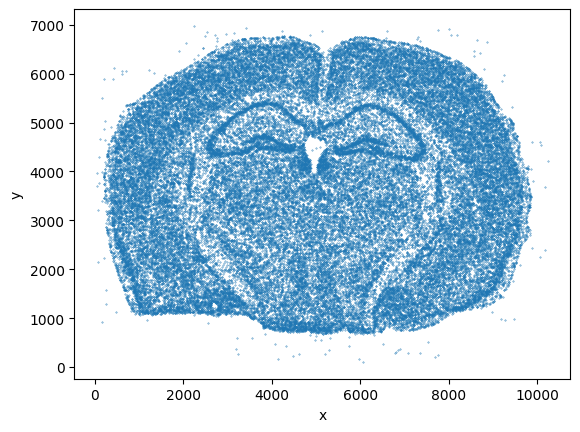

In [4]:
_ = coordinate_df[::1000].plot.scatter(x="x", y="y", s=0.1)

## Running the ovrlpy pipeline

ovrlpy provides a convenience function `run` to run the entire pipeline. 
The function creates a signal integrity map, a signal strength map and a Visualizer obejcet to visualize the results.

In [5]:
signal_integrity, signal_strength, visualizer = ovrlpy.run(
    df=coordinate_df, cell_diameter=10, n_expected_celltypes=30, n_workers=8
)

Running vertical adjustment
Creating gene expression embeddings for visualization:
Analyzing in 3d mode:
determining pseudocells:
found 62341 pseudocells
sampling expression:


100%|██████████| 88/88 [02:21<00:00,  1.61s/it]


Modeling 30 pseudo-celltype clusters;
Creating signal integrity map:


 94%|█████████▍| 296/315 [06:33<00:21,  1.15s/it]/dh-projects/ag-ishaque/analysis/muellni/envs/ovrlpy/lib/python3.12/site-packages/ovrlpy/_utils.py:397: RuntimeWarning: invalid value encountered in divide
  spatial_patch_cosine_similarity[patch_signal_mask] = np.sum(
100%|██████████| 315/315 [06:41<00:00,  1.28s/it]


## Visualizing results

The visualizer object has a plotting method to show the embeddings of the sampled gene expression signal.

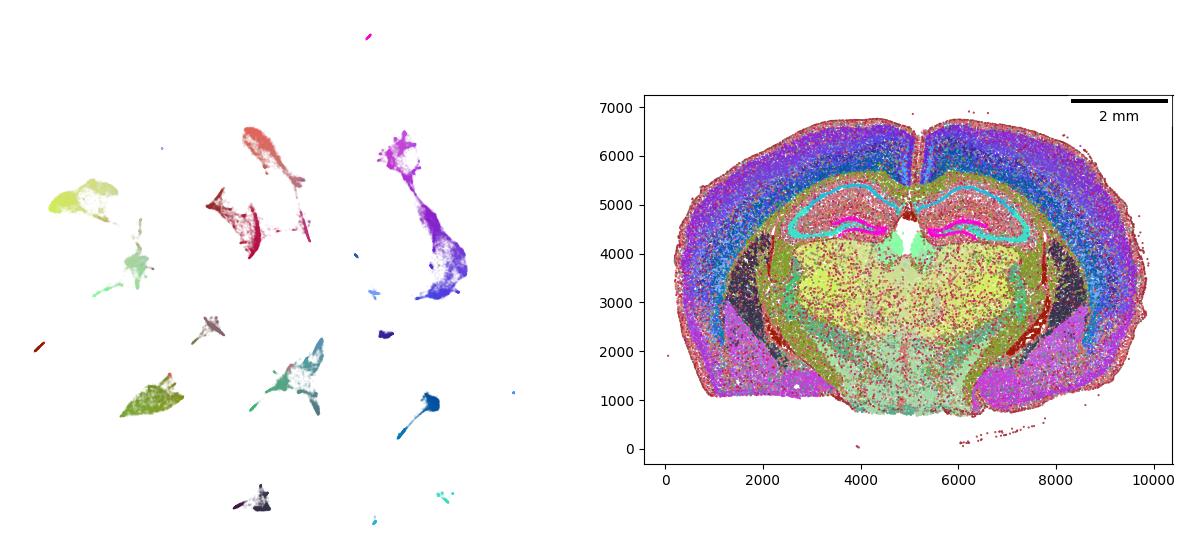

In [6]:
visualizer.plot_fit()

We can annotate the UMAP using external, single-cell derived cell type signatures to help interpret the cell type clusters in the gene-expression embedding:

In [10]:
signatures = pd.read_csv(signature_matrix_file, index_col=0).T.loc[
    :, lambda df: df.columns.isin(visualizer.genes)
]

signatures = signatures.groupby(
    lambda x: x.split("_")[1].split(" ")[0].split("-")[0]
).mean()

signatures.index = signatures.index.str.replace("/", "-")
signatures.index.name = "celltype"

signatures.iloc[:5, :5]

feature   Sox17   Col19a1  2010300C02Rik     Satb2      Nrp2
celltype                                                    
Astro       0.0  0.000000       0.000000  0.000000  1.316010
CA1         0.0  0.000000       7.463820  2.937198  0.693990
CA2         0.0  0.000000       9.586734  0.000000  2.942782
CA3         0.0  0.051941       6.305638  0.000000  6.810690
CR          0.0  0.000000       0.000000  0.000000  0.000000

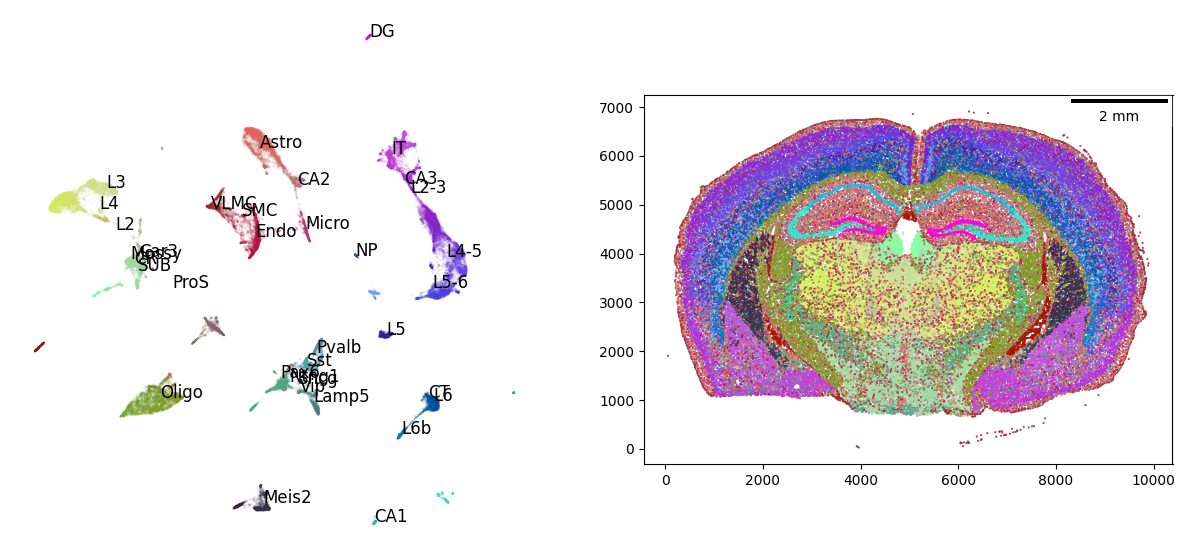

In [11]:
visualizer.fit_signatures(signatures)
visualizer.plot_fit()

In the same way, the signal integrity map can be visualized, where visualization is cut off at regions below a certain signal strength threshold:

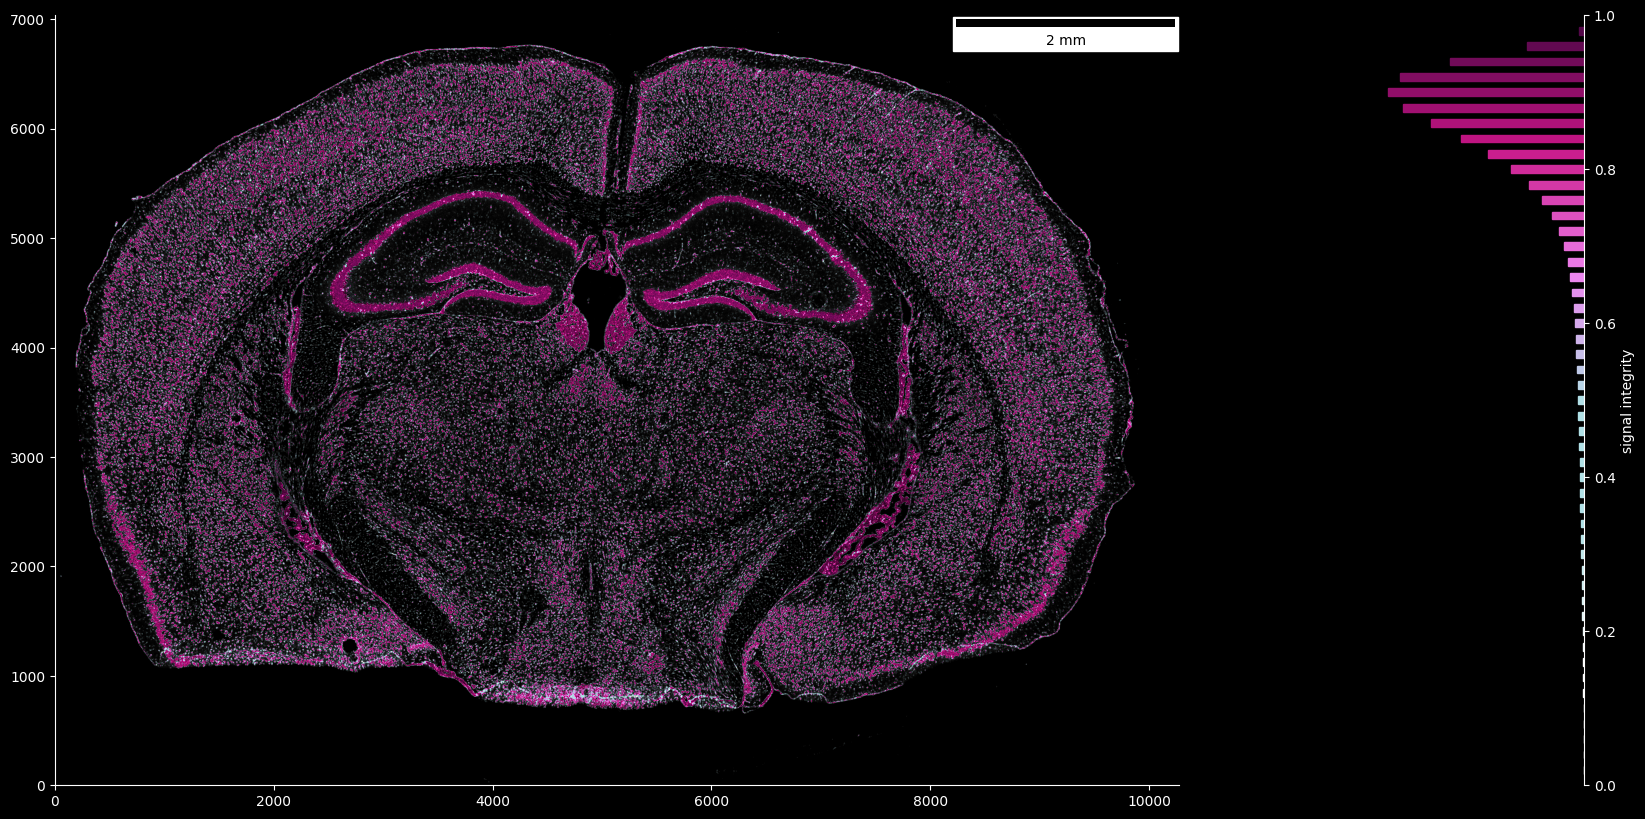

In [12]:
fig, ax = ovrlpy.plot_signal_integrity(
    signal_integrity, signal_strength, signal_threshold=3
)

## Detecting doublets 

We can detect individual doublet events with ovrlpy, again setting a signal strength threshold to filter out low-transcript regions:

In [13]:
doublet_df = ovrlpy.detect_doublets(
    signal_integrity, signal_strength, minimum_signal_strength=3, integrity_sigma=2
)

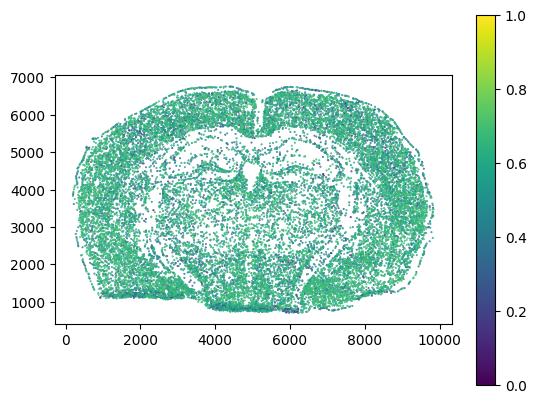

In [14]:
_ = plt.scatter(
    doublet_df["x"],
    doublet_df["y"],
    c=doublet_df["integrity"],
    s=0.2,
    cmap="viridis",
    vmin=0,
    vmax=1,
)
_ = plt.gca().set_aspect("equal")
_ = plt.colorbar()

Having sampled regions of potential doublets, we can visualize them as close-up transcriptome molecule clouds through the Visualizer's learned color embeddings - by providing their (x, y) locations to `ovrlpy.plot_region_of_interest`

/dh-projects/ag-ishaque/analysis/muellni/envs/ovrlpy/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


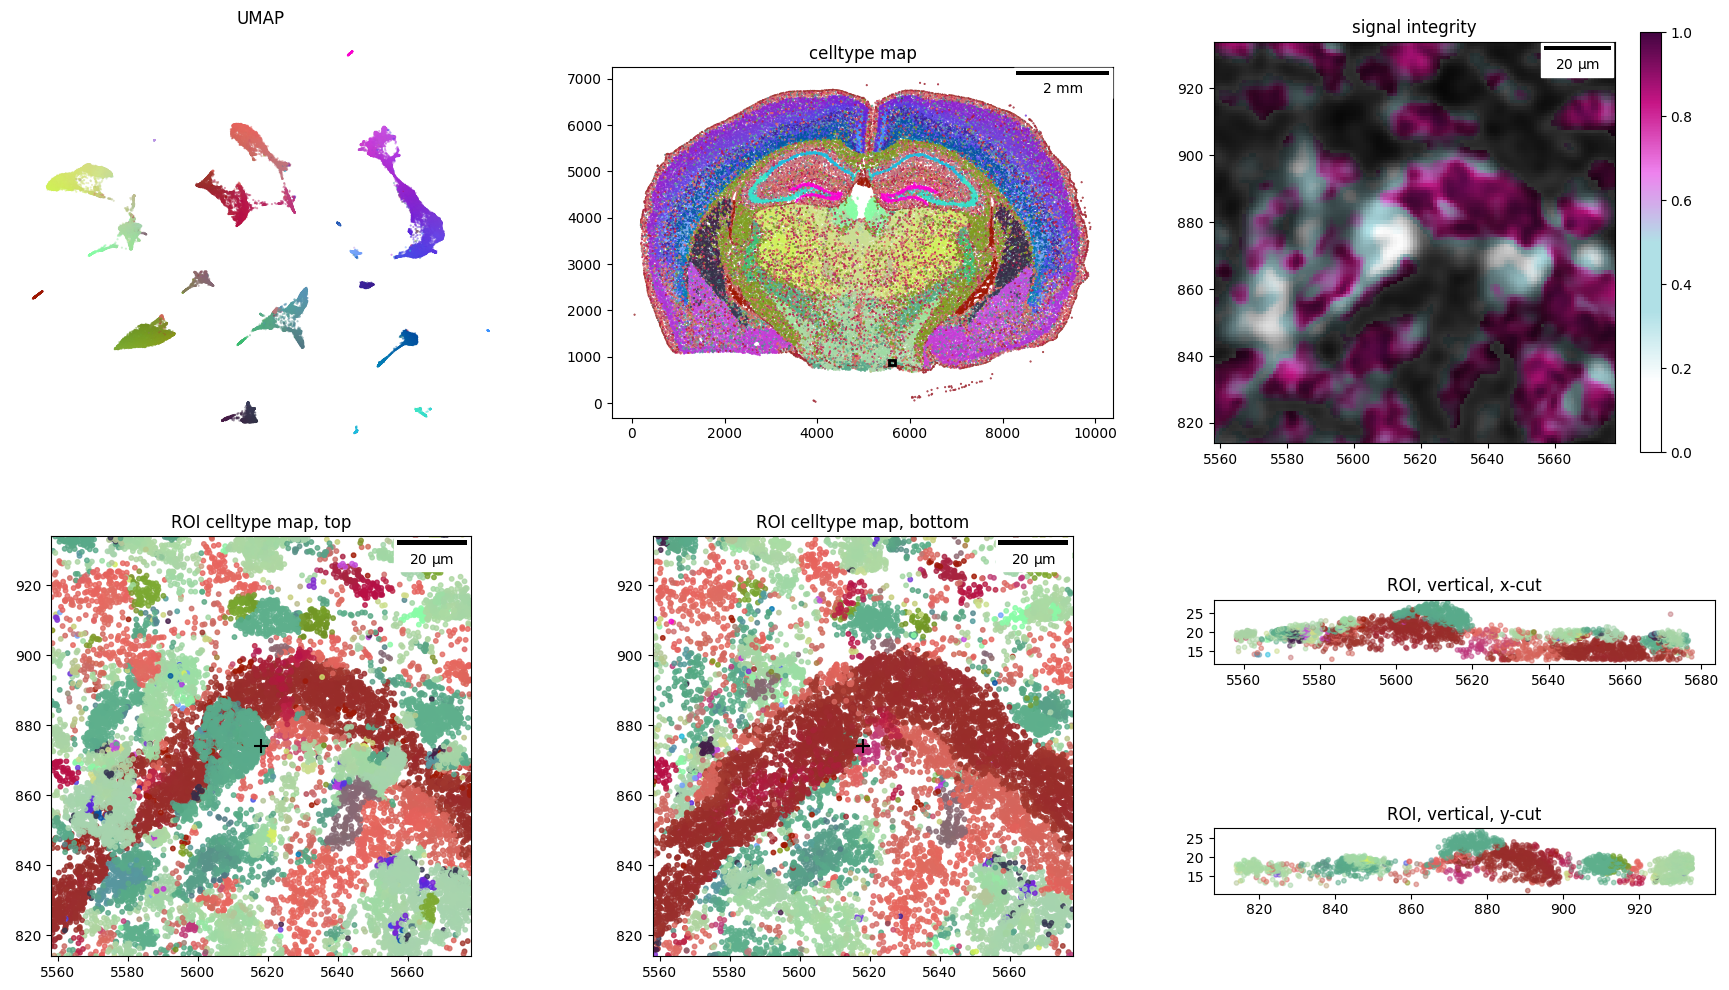

In [15]:
doublet_case = 0

x, y = doublet_df.loc[doublet_case, ["x", "y"]]

_ = ovrlpy.plot_region_of_interest(
    x, y, coordinate_df, visualizer, signal_integrity, signal_strength, window_size=60
)

## Other functionality

Furthermore, we can save the visualizer object to file for later use leveraging the `pickle` module

In [16]:
import pickle

with open("my_analysis.pickle", "wb") as file:
    pickle.dump(visualizer, file)

... and easily reload it if needed.

In [17]:
with open("my_analysis.pickle", "rb") as file:
    visualizer = pickle.load(file)

Additionally, the analysis has produced a global z-level adjustment of the transcriptome coordinates, which can be used to create a z-stack of adjacent, aligned sections in silico:

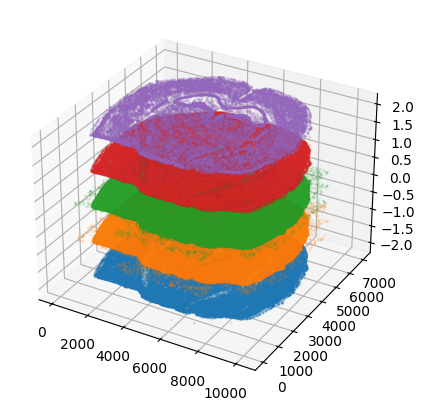

In [18]:
plt.figure(figsize=(20, 5))

ax = plt.subplot(111, projection="3d")

for i in range(-2, 3):
    subset = coordinate_df[(coordinate_df.z - coordinate_df.z_delim).between(i, i + 1)]

    ax.scatter(
        subset.x[::100],
        subset.y[::100],
        np.zeros(1 + (len(subset) // 100)) + i,
        s=1,
        alpha=0.1,
    )